In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import itertools
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')

In [0]:
def plot_data(X, y_label=None, y_pred=None, rows=5, cols=4):
    """Plot the light curve and the associated label. Trims zeroes in X"""
    plot=plt.figure(figsize=(rows * 4, 15))
    for i in range(rows * cols):
        plt.subplot(rows,cols,i+1)
        last_nonzero = np.max(np.nonzero(X[i,:,0]))
        plt.plot(X[i,:last_nonzero,0], '#a0a0a0', label='Light Curve')
        if y_label is not None:
            plt.plot(y_label[i,:last_nonzero], 'r', label='Label')
        if y_pred is not None:
            plt.plot(y_pred[i,:last_nonzero], 'b', label='Prediction')
        if i == 0:
            plt.legend()

    return plot


def plot_history(lc):
    plot=plt.figure()
    plt.plot(lc.history['f1_m'], label = 'Training F1')
    plt.plot(lc.history['val_f1_m'], label = 'Validation F1')
    plt.legend()
    return plot


def plot_curve(y_label, y_pred):
    label_cast_flat = list(itertools.chain(*y_label.astype(int)))
    pred_flat = list(itertools.chain(*y_pred))
    precision, recall, threshold = precision_recall_curve(label_cast_flat, pred_flat)
    f1 = 2 * (precision * recall) / (precision + recall)
    plot = plt.figure()
    plt.plot(threshold, precision[1:], label='Precision')
    plt.plot(threshold, recall[1:], label='Recall')
    plt.plot(threshold, f1[1:], label='F1')
    plt.legend()
    print('Best threshold: ', threshold[np.argmax(f1)-1])
    print('Best F1-Score: ', np.max(f1))
    return plot

In [0]:
# Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle

In [0]:
X_train = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/X_train.p', 'rb'))
y_train = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/y_train.p', 'rb'))
X_test = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/X_test.p', 'rb'))
y_test = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/y_test.p', 'rb'))
X_dev = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/X_dev.p', 'rb'))
y_dev = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/y_dev.p', 'rb'))


In [0]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import tensorflow as tf
from tensorflow.keras import layers

In [0]:
def dev_curve(model):
    pred = model.predict_proba(X_dev)
    return plot_curve(y_dev, pred)

In [0]:
# LSTM single layer

lstm_1 = tf.keras.Sequential()

# Adding the first layer
lstm_1.add(layers.LSTM(units=200, return_sequences=True, input_shape=(None, 1)))
lstm_1.add(layers.Dropout(0.2))

# Output layer
lstm_1.add(layers.Dense(units=1, activation='sigmoid'))

lstm_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
lstm_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 200)         161600    
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
import numpy as np
import tensorflow as tf
import random as rn

def reset_seed():
    np.random.seed(42)
    rn.seed(12345)
    tf.random.set_seed(1234)

In [0]:
reset_seed()
lc_lstm_1=lstm_1.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1, workers=4)

Train on 500 samples, validate on 100 samples
Epoch 1/50
500/500 [==============================] - 6s 13ms/sample - loss: 0.4156 - acc: 0.9268 - f1_m: 0.1468 - val_loss: 0.5156 - val_acc: 0.8428 - val_f1_m: 0.2021
Epoch 2/50
500/500 [==============================] - 1s 3ms/sample - loss: 0.1986 - acc: 0.9495 - f1_m: 0.2945 - val_loss: 0.1311 - val_acc: 0.9626 - val_f1_m: 0.1806
Epoch 3/50
500/500 [==============================] - 1s 3ms/sample - loss: 0.1072 - acc: 0.9679 - f1_m: 0.3645 - val_loss: 0.0855 - val_acc: 0.9705 - val_f1_m: 0.6717
Epoch 4/50
500/500 [==============================] - 1s 3ms/sample - loss: 0.0761 - acc: 0.9716 - f1_m: 0.6158 - val_loss: 0.0751 - val_acc: 0.9699 - val_f1_m: 0.7025
Epoch 5/50
500/500 [==============================] - 1s 3ms/sample - loss: 0.0670 - acc: 0.9723 - f1_m: 0.6018 - val_loss: 0.0758 - val_acc: 0.9704 - val_f1_m: 0.7209
Epoch 6/50
500/500 [==============================] - 1s 3ms/sample - loss: 0.0647 - acc: 0.9727 - f1_m: 0.6239 -

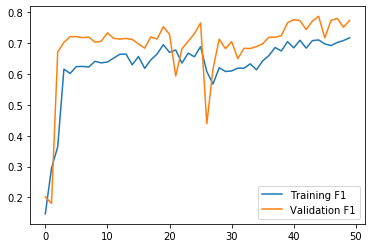

In [0]:
plot=plot_history(lc_lstm_1)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/lc_lstm_1.svg')
plot.show()

Best threshold:  0.23537186
Best F1-Score:  0.7097003645416554


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


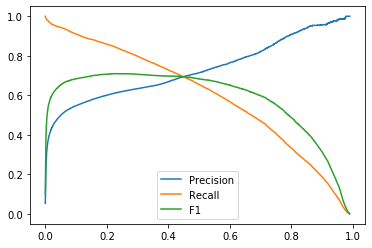

In [0]:
plot=dev_curve(lstm_1)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/lstm_1_dev.svg')
plot.show()

In [0]:
lstm_1.evaluate(X_dev, y_dev)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.064556173235178, 0.97116, 0.51638806]

In [0]:
# LSTM double layer

lstm_2 = tf.keras.Sequential()

# Adding the first layer
lstm_2.add(layers.LSTM(units=200, return_sequences=True, input_shape=(None, 1)))
lstm_2.add(layers.Dropout(0.2))

lstm_2.add(layers.LSTM(units=100, return_sequences=True, input_shape=(None, 200)))
lstm_2.add(layers.Dropout(0.2))


# Output layer
lstm_2.add(layers.Dense(units=1, activation='sigmoid'))

lstm_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
lstm_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 200)         161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         120400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
reset_seed()
lc_lstm_2=lstm_2.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1, workers=4)

Train on 500 samples, validate on 100 samples
Epoch 1/50
500/500 [==============================] - 6s 11ms/sample - loss: 0.3356 - acc: 0.9309 - f1_m: 0.1987 - val_loss: 0.1093 - val_acc: 0.9693 - val_f1_m: 0.6455
Epoch 2/50
500/500 [==============================] - 2s 5ms/sample - loss: 0.0831 - acc: 0.9704 - f1_m: 0.6030 - val_loss: 0.0773 - val_acc: 0.9660 - val_f1_m: 0.6981
Epoch 3/50
500/500 [==============================] - 2s 5ms/sample - loss: 0.0671 - acc: 0.9724 - f1_m: 0.6214 - val_loss: 0.0722 - val_acc: 0.9693 - val_f1_m: 0.7197
Epoch 4/50
500/500 [==============================] - 2s 5ms/sample - loss: 0.0653 - acc: 0.9719 - f1_m: 0.6279 - val_loss: 0.0722 - val_acc: 0.9690 - val_f1_m: 0.7280
Epoch 5/50
500/500 [==============================] - 2s 5ms/sample - loss: 0.0665 - acc: 0.9709 - f1_m: 0.5967 - val_loss: 0.0689 - val_acc: 0.9712 - val_f1_m: 0.7141
Epoch 6/50
500/500 [==============================] - 2s 5ms/sample - loss: 0.0614 - acc: 0.9726 - f1_m: 0.6087 -

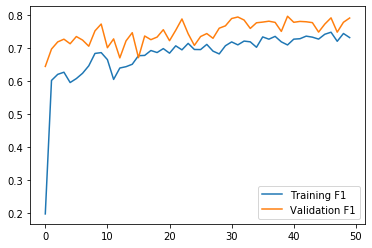

In [0]:
plot=plot_history(lc_lstm_2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/lc_lstm_2.svg')
plot.show()

Best threshold:  0.41464627
Best F1-Score:  0.7356731560186456


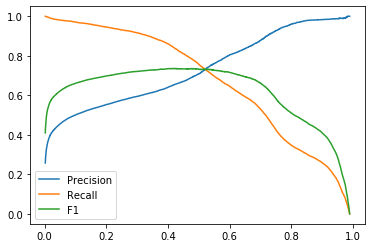

In [0]:
plot=dev_curve(lstm_2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/lstm_2_dev.svg')
plot.show()

In [0]:
lstm_2.evaluate(X_dev, y_dev)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.053479048162698745, 0.9736049, 0.5518519]

In [0]:
# GRU single layer

gru_1 = tf.keras.Sequential()

# Adding the first layer
gru_1.add(layers.GRU(units=200, return_sequences=True, input_shape=(None, 1)))
gru_1.add(layers.Dropout(0.2))

# Output layer
gru_1.add(layers.Dense(units=1, activation='sigmoid'))

gru_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
gru_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 200)         121800    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
reset_seed()
lc_gru_1=gru_1.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1, workers=4)

Train on 500 samples, validate on 100 samples
Epoch 1/50
500/500 [==============================] - 3s 6ms/sample - loss: 0.4505 - acc: 0.9339 - f1_m: 0.2204 - val_loss: 0.1057 - val_acc: 0.9695 - val_f1_m: 0.5257
Epoch 2/50
500/500 [==============================] - 1s 2ms/sample - loss: 0.1089 - acc: 0.9709 - f1_m: 0.5678 - val_loss: 0.1035 - val_acc: 0.9671 - val_f1_m: 0.6478
Epoch 3/50
500/500 [==============================] - 1s 2ms/sample - loss: 0.0761 - acc: 0.9713 - f1_m: 0.5801 - val_loss: 0.0773 - val_acc: 0.9710 - val_f1_m: 0.6592
Epoch 4/50
500/500 [==============================] - 1s 2ms/sample - loss: 0.0694 - acc: 0.9721 - f1_m: 0.5871 - val_loss: 0.0733 - val_acc: 0.9702 - val_f1_m: 0.7073
Epoch 5/50
500/500 [==============================] - 1s 2ms/sample - loss: 0.0650 - acc: 0.9724 - f1_m: 0.6155 - val_loss: 0.0715 - val_acc: 0.9698 - val_f1_m: 0.7175
Epoch 6/50
500/500 [==============================] - 1s 2ms/sample - loss: 0.0632 - acc: 0.9725 - f1_m: 0.6247 - 

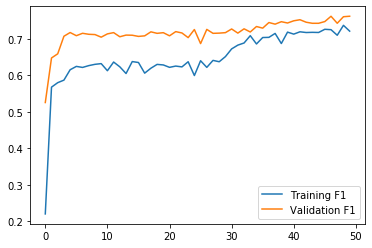

In [0]:
plot=plot_history(lc_gru_1)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/lc_gru_1.svg')
plot.show()

Best threshold:  0.26448616
Best F1-Score:  0.7427830905353472


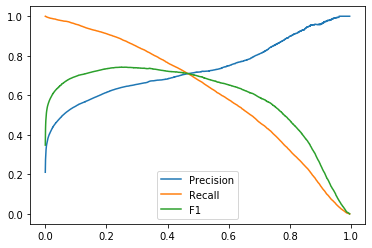

In [0]:
plot=dev_curve(gru_1)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/gru_1_dev.svg')
plot.show()

In [0]:
gru_1.evaluate(X_dev, y_dev)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05613848879933357, 0.97198, 0.52616996]

In [10]:
# GRU double layer

gru_2 = tf.keras.Sequential()

# Adding the first layer
gru_2.add(layers.GRU(units=200, return_sequences=True, input_shape=(None, 1)))
gru_2.add(layers.Dropout(0.2))

gru_2.add(layers.GRU(units=100, return_sequences=True, input_shape=(None, 200)))
gru_2.add(layers.Dropout(0.2))


# Output layer
gru_2.add(layers.Dense(units=1, activation='sigmoid'))

gru_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m])
gru_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 200)         121800    
_________________________________________________________________
dropout (Dropout)            (None, None, 200)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 100)         90600     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 212,501
Trainable params: 212,501
Non-trainable params: 0
_________________________________________________________________


In [13]:
reset_seed()
lc_gru_2=gru_2.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1, workers=4)

Train on 500 samples, validate on 100 samples
Epoch 1/50
500/500 [==============================] - 9s 18ms/sample - loss: 0.3534 - acc: 0.9309 - f1_m: 0.2289 - val_loss: 0.1173 - val_acc: 0.9641 - val_f1_m: 0.7008
Epoch 2/50
500/500 [==============================] - 2s 4ms/sample - loss: 0.0821 - acc: 0.9688 - f1_m: 0.5317 - val_loss: 0.0736 - val_acc: 0.9714 - val_f1_m: 0.6124
Epoch 3/50
500/500 [==============================] - 2s 4ms/sample - loss: 0.0669 - acc: 0.9722 - f1_m: 0.6235 - val_loss: 0.0739 - val_acc: 0.9689 - val_f1_m: 0.7236
Epoch 4/50
500/500 [==============================] - 2s 4ms/sample - loss: 0.0638 - acc: 0.9722 - f1_m: 0.6212 - val_loss: 0.0680 - val_acc: 0.9711 - val_f1_m: 0.7104
Epoch 5/50
500/500 [==============================] - 2s 4ms/sample - loss: 0.0607 - acc: 0.9723 - f1_m: 0.6253 - val_loss: 0.0690 - val_acc: 0.9692 - val_f1_m: 0.7266
Epoch 6/50
500/500 [==============================] - 2s 4ms/sample - loss: 0.0601 - acc: 0.9729 - f1_m: 0.6268 -

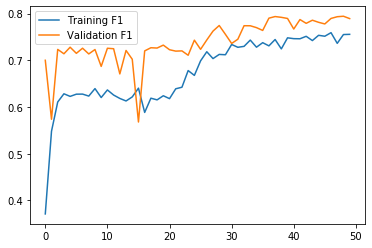

In [0]:
plot=plot_history(lc_gru_2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/lc_gru_2.svg')
plot.show()

Best threshold:  0.34465525
Best F1-Score:  0.7592174913693901


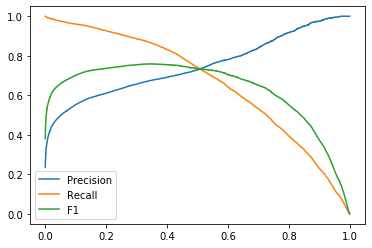

In [0]:
plot=dev_curve(gru_2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/gru_2_dev.svg')
plot.show()

In [0]:
gru_2.evaluate(X_dev, y_dev)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05186969503760338, 0.97458506, 0.56227523]

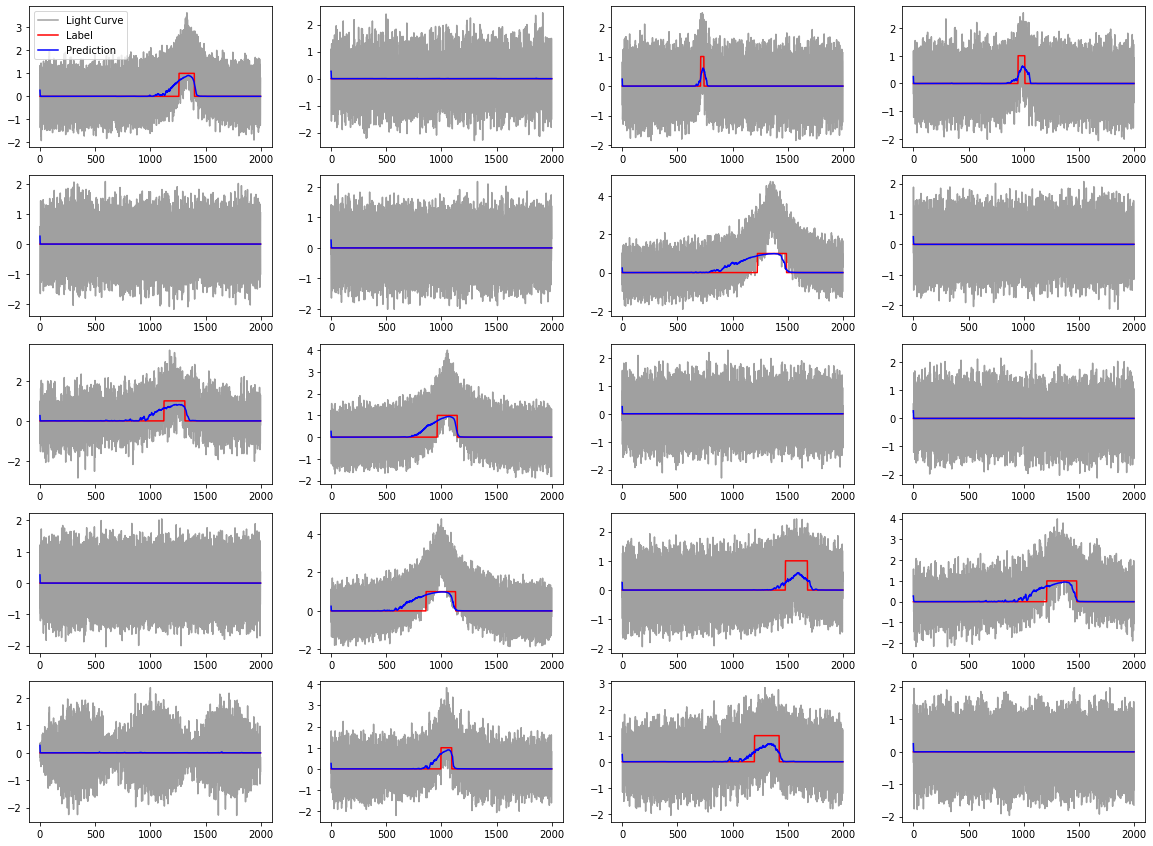

In [0]:
plot=plot_data(X_dev, y_dev, gru_2.predict_proba(X_dev))
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/gru_2_dev_example.svg')
plot.show()

In [0]:
# Load MOA data
X_gb_events = pickle.load(open('/content/drive/My Drive/pTSA_microlensing/X_gb_events.p', 'rb'))

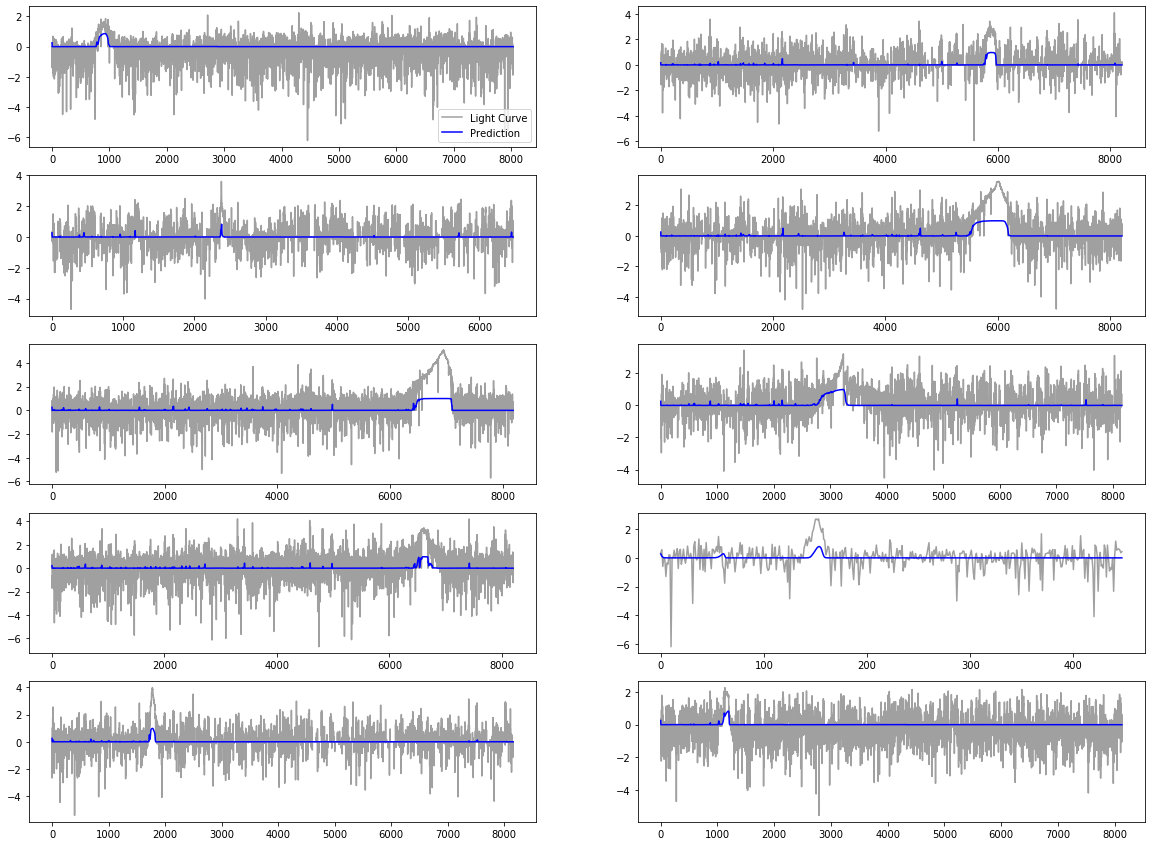

In [15]:
plot=plot_data(X_gb_events, y_pred=gru_2.predict_proba(X_gb_events), cols=2)
plot.savefig('/content/drive/My Drive/pTSA_microlensing/graph/gru_2_real.svg')
plot.show()